# Kaggle Competition: MultiClass classification

<img src="https://octodex.github.com/images/octocat-de-los-muertos.jpg" alt="Cat" title="Cat" width="350" height="200" />
*(image from octodex github)*

**We will first use the dataset training, metadata image and sentiment data to predict the Adoption Speed**

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# LightGBM
import lightgbm as lgb

# Load scikit's classifier library
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold,RandomizedSearchCV


from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, f1_score

from xgboost import XGBClassifier, plot_importance

## Data Preparation 

In [19]:
#Load Data
train =pd.read_csv(r'C:\Users\alorenzodebrionne\Documents\BusinessDecision\Projects\Kaggle\train_features.csv',index_col=0)

In [20]:
print(train.columns)

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'BreedName1', 'BreedName2', 'ColorName1', 'ColorName2', 'ColorName3',
       'StateName', 'sentiment_document_score', 'sentiment_document_magnitude',
       'metadata_topicality_max', 'metadata_topicality_mean',
       'metadata_topicality_min', 'metadata_topicality_0_mean',
       'metadata_topicality_0_max', 'metadata_topicality_0_min',
       'L_metadata_0_cat_sum', 'L_metadata_0_dog_sum',
       'L_metadata_any_cat_sum', 'L_metadata_any_dog_sum', 'ImageId',
       'pixel_mean', 'blur_mean', 'pixel_min', 'blur_min', 'pixel_max',
       'blur_max', 'pixel_sum', 'blur_sum', 'L_Color1', 'L_Color2', 'L_Color3',
       'L_Breed1', 'L_Breed2', 'L_Name_missing', 'L_Name_incorrect',
       'L_

### Missing Values

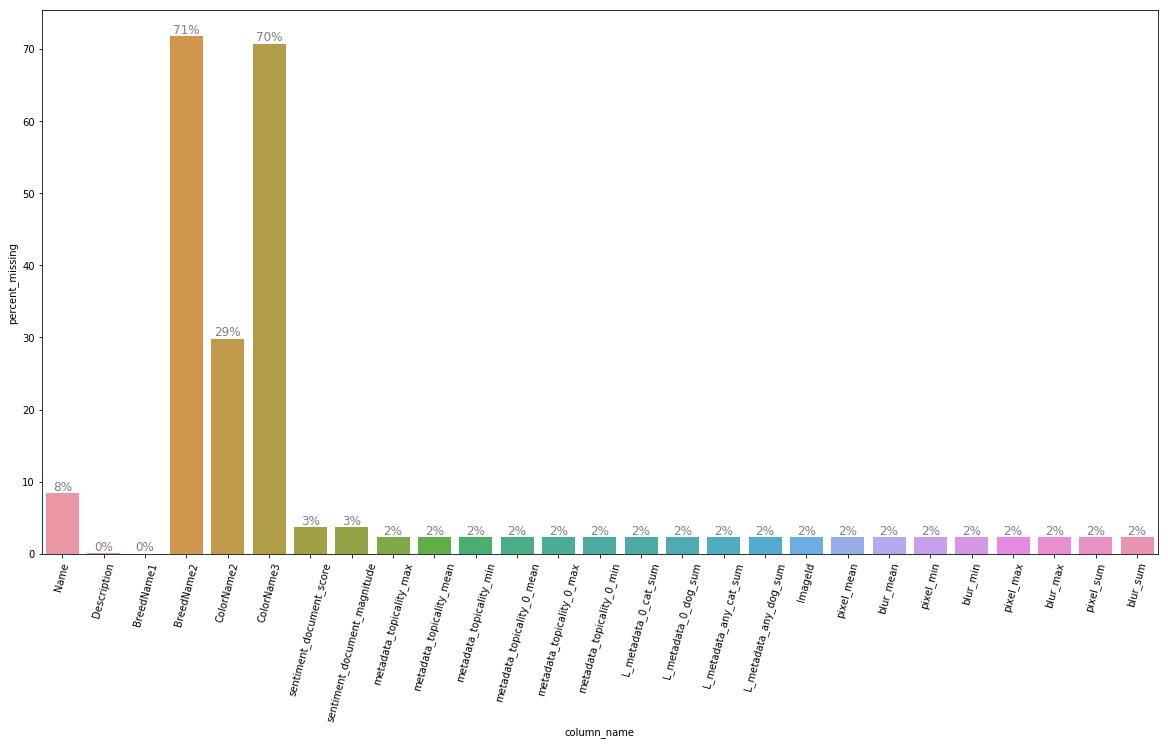

In [21]:
columns = train.columns
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

missing_value_df =missing_value_df[missing_value_df['percent_missing']>0]
missing_value_df


plt.figure(figsize=(20, 10))
ax = sns.barplot(x="column_name", y="percent_missing", data=missing_value_df, label='Sales')
ax.set_xticklabels(ax.get_xticklabels(),rotation=75)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % round(p.get_height(),2) + '%', 
            fontsize=12, color='grey', ha='center', va='bottom') 
    
plt.show()

We will not keep variables with more than 50% of observations.
Name, Description, BreedName2, ColorName3 will not be included. For the others values we will replace the numeric by the median and create a category "missing" for categorical variables  

In [22]:
# Cannot be used for this analysis (IDs, Texts...)
train_analysis = train.drop(["Name","Description","BreedName2","ColorName3",'Name','Breed1','Breed2','RescuerID','Description',
                            'BreedName1','Color1', 'Color2', 'Color3','Age','State'],axis=1)

for col in ['sentiment_document_score', 'sentiment_document_magnitude','metadata_topicality_max','metadata_topicality_mean','metadata_topicality_min',
           'metadata_topicality_0_mean','metadata_topicality_0_max','metadata_topicality_0_min','L_metadata_0_dog_sum',
           'L_metadata_0_cat_sum','L_metadata_any_dog_sum','L_metadata_any_cat_sum','pixel_mean','pixel_min','pixel_max','pixel_sum',
           'blur_min','blur_max','blur_sum','blur_mean']:
    train_analysis[col].fillna((train_analysis[col].median()), inplace=True)
    
# replacing na values with No Color 
train_analysis["ColorName2"].fillna("No Color", inplace = True) 


In [23]:
train_analysis.columns

Index(['Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'VideoAmt', 'PetID',
       'PhotoAmt', 'AdoptionSpeed', 'ColorName1', 'ColorName2', 'StateName',
       'sentiment_document_score', 'sentiment_document_magnitude',
       'metadata_topicality_max', 'metadata_topicality_mean',
       'metadata_topicality_min', 'metadata_topicality_0_mean',
       'metadata_topicality_0_max', 'metadata_topicality_0_min',
       'L_metadata_0_cat_sum', 'L_metadata_0_dog_sum',
       'L_metadata_any_cat_sum', 'L_metadata_any_dog_sum', 'ImageId',
       'pixel_mean', 'blur_mean', 'pixel_min', 'blur_min', 'pixel_max',
       'blur_max', 'pixel_sum', 'blur_sum', 'L_Color1', 'L_Color2', 'L_Color3',
       'L_Breed1', 'L_Breed2', 'L_Name_missing', 'L_Name_incorrect',
       'L_Fee_Free', 'N_pets_total', 'L_NoPhoto', 'L_NoVideo', 'Log_Age',
       'L_scoreneg'],
      dtype='object')

### Categorical features Encoding 

In [24]:
#Label Encoding Breed
#One Hot Encoding: ColorName1,ColorName2,StateName
train_analysis = pd.concat([train_analysis.drop('StateName', axis=1),pd.get_dummies(train_analysis['StateName'], prefix='State')], axis=1)

col=['ColorName1','ColorName2','Health', 'Gender', 'Dewormed','Type','MaturitySize', 'Sterilized','Vaccinated']
for i in col:
    train_analysis = pd.concat([train_analysis.drop(i, axis=1),pd.get_dummies(train_analysis[i], prefix=i)], axis=1)

### Train, Test & Validation Sets

In [25]:
train_analysis.columns

Index(['FurLength', 'Quantity', 'Fee', 'VideoAmt', 'PetID', 'PhotoAmt',
       'AdoptionSpeed', 'sentiment_document_score',
       'sentiment_document_magnitude', 'metadata_topicality_max',
       'metadata_topicality_mean', 'metadata_topicality_min',
       'metadata_topicality_0_mean', 'metadata_topicality_0_max',
       'metadata_topicality_0_min', 'L_metadata_0_cat_sum',
       'L_metadata_0_dog_sum', 'L_metadata_any_cat_sum',
       'L_metadata_any_dog_sum', 'ImageId', 'pixel_mean', 'blur_mean',
       'pixel_min', 'blur_min', 'pixel_max', 'blur_max', 'pixel_sum',
       'blur_sum', 'L_Color1', 'L_Color2', 'L_Color3', 'L_Breed1', 'L_Breed2',
       'L_Name_missing', 'L_Name_incorrect', 'L_Fee_Free', 'N_pets_total',
       'L_NoPhoto', 'L_NoVideo', 'Log_Age', 'L_scoreneg', 'State_Johor',
       'State_Kedah', 'State_Kelantan', 'State_Kuala Lumpur', 'State_Labuan',
       'State_Melaka', 'State_Negeri Sembilan', 'State_Pahang', 'State_Perak',
       'State_Pulau Pinang', 'State_Saba

We are going to use 80% of the data for training and the remaining 20% to test the model. 
We will tune the hyperparameters using cross validation datasets. 

In [26]:
#Extracting Features and Output
ids=train_analysis[['PetID','ImageId']]
train_analysis=train_analysis.drop(['PetID','ImageId'],axis=1)

X, y = train_analysis.loc[:, train_analysis.columns != 'AdoptionSpeed'], train_analysis['AdoptionSpeed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

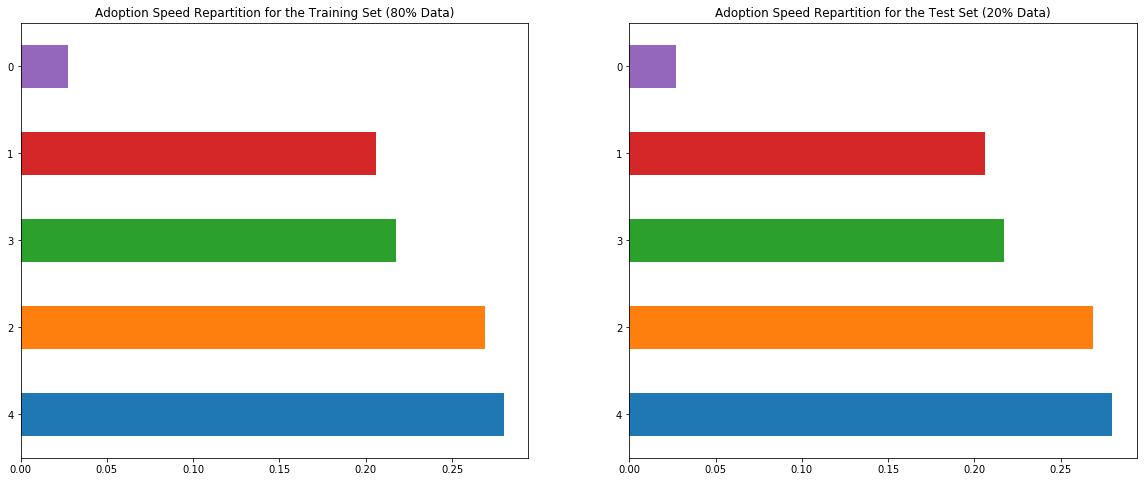

In [27]:
plt.subplot(1, 2, 1)
prob_train  =y_train.value_counts(normalize=True)
prob_train.plot(kind='barh',figsize =(20,6))
plt.title('Adoption Speed Repartition for the Training Set (80% Data)')
plt.subplot(1, 2, 2)

prob  =y_test.value_counts(normalize=True)
prob.plot(kind='barh', figsize =(20,8))
plt.title('Adoption Speed Repartition for the Test Set (20% Data)')
plt.show()

In [28]:
print(len(train_analysis.columns))

88


## Features Selection

Select the features by examining only the training set and avoid overfitting (using XGboost)

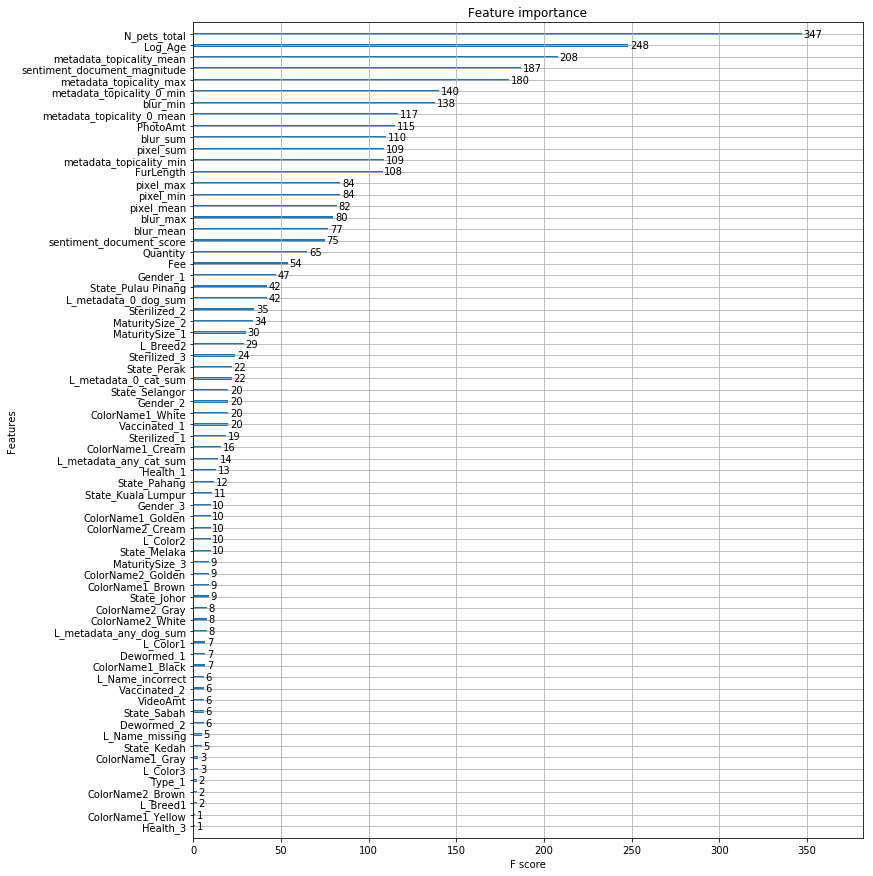

In [29]:
model = XGBClassifier()
model.fit(X_train, y_train)
# plot feature importance

fig, ax = plt.subplots(1,1,figsize=(12,15))
plot_importance(model, ax=ax )
plt.show()

## Let's Begin with a Random Forest Classifer 

In a first step we divide our data into a training(80% of Data) and a testing set (20% of Data). To tune the hyperparameter and avoid overfitting we used the technique of Cross Validation (CV). For K-Fold CV, we further split our training set into K number of subsets, called folds.We then iteratively fit the model K times, each time training the data on K-1 of the folds and evaluating on the Kth fold. For hyperparameter tuning, we perform many iterations of the entire K-Fold CV process, each time using different model settings. We then compare all of the models, select the best one! At the very end of training, we average the performance on each of the folds to come up with final validation metrics for the model.

<img src="https://i.imgur.com/amekoez.jpg" alt="Cat" title="Cat" width="800" height="600" />

### Evaluation with Cohen Kappa measure

In [30]:
def evaluate(model, test_features, test_labels):
  
    predictions = model.predict(test_features)
   
    cohen_kappa= cohen_kappa_score(test_labels, predictions)
    accuracy=accuracy_score(test_labels,predictions)
    f1=f1_score(y_test,predictions,average='micro')
    
    #Confusion Matrix
    cm = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(20,6))
    
    sns.heatmap(cm, annot=True)
    plt.title('Confusion matrix')
    plt.figure(figsize = (5,4))
    plt.show()
    #Evaluation Metrics
    print('Cohen Kappa: {:0.2f}.'.format(cohen_kappa))
    print('Accuracy Score: {:0.2f}%.'.format(accuracy))
    print('F1 Score: {:0.2f}%.'.format(f1))
    

This will try out 3 X 2 X 4 X 3 X 2 X 1 = **144 combinations of settings!**


In [34]:
# Number of trees in random forest
n_estimators = [200, 300, 500]
# Number of features to consider at every split
max_features = [2, 3]
# Maximum number of levels in tree
max_depth =[80, 90, 100, 110]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split =[8, 10, 12]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 5]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
gridParams = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(gridParams)

{'min_samples_split': [8, 10, 12], 'n_estimators': [200, 300, 500], 'bootstrap': [True], 'min_samples_leaf': [4, 5], 'max_features': [2, 3], 'max_depth': [80, 90, 100, 110, None]}


In [36]:
# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = gridParams, n_iter = 100, cv = 5, verbose=2, random_state=42)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] min_samples_split=8, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=80 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_split=8, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=80, total=   3.2s
[CV] min_samples_split=8, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=80 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV]  min_samples_split=8, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=80, total=   3.3s
[CV] min_samples_split=8, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=80 
[CV]  min_samples_split=8, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=80, total=   3.3s
[CV] min_samples_split=8, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=80 
[CV]  min_samples_split=8, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=80, total=   3.3s
[CV] min_samples_split=8, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=80 
[CV]  min_samples_split=8, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=80, total=   3.6s
[CV] min_samples_split=12, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=90 
[CV]  min_samples_split=12, n_estimators=200, bootstrap=Tru

[CV]  min_samples_split=10, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90, total=   5.9s
[CV] min_samples_split=10, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90 
[CV]  min_samples_split=10, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90, total=   5.2s
[CV] min_samples_split=10, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90 
[CV]  min_samples_split=10, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90, total=   5.1s
[CV] min_samples_split=10, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90 
[CV]  min_samples_split=10, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90, total=   5.3s
[CV] min_samples_split=10, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=110 
[CV]  min_samples_split=10, n_estimators=500, boots

[CV]  min_samples_split=8, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=90, total=   1.5s
[CV] min_samples_split=8, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=90 
[CV]  min_samples_split=8, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=90, total=   1.4s
[CV] min_samples_split=8, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=90 
[CV]  min_samples_split=8, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=90, total=   1.4s
[CV] min_samples_split=8, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=90 
[CV]  min_samples_split=8, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=90, total=   1.5s
[CV] min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=80 
[CV]  min_samples_split=12, n_estimators=300, bootstrap=Tru

[CV]  min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110, total=   1.5s
[CV] min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110 
[CV]  min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110, total=   2.2s
[CV] min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110 
[CV]  min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110, total=   1.8s
[CV] min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110 
[CV]  min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110, total=   1.6s
[CV] min_samples_split=12, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=110 
[CV]  min_samples_split=12, n_estimators=500

[CV]  min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None, total=   2.3s
[CV] min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None 
[CV]  min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None, total=   2.2s
[CV] min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None 
[CV]  min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None, total=   2.2s
[CV] min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None 
[CV]  min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None, total=   2.4s
[CV] min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=None 
[CV]  min_samples_split=8, n_estimato

[CV]  min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=80, total=   5.1s
[CV] min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=80 
[CV]  min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=80, total=   6.1s
[CV] min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=80 
[CV]  min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=80, total=   9.6s
[CV] min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=80 
[CV]  min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=80, total=   5.6s
[CV] min_samples_split=8, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110 
[CV]  min_samples_split=8, n_estimators=200, bootstrap=True

[CV]  min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110, total=   2.3s
[CV] min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110 
[CV]  min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110, total=   2.3s
[CV] min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110 
[CV]  min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110, total=   2.3s
[CV] min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110 
[CV]  min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=110, total=   2.4s
[CV] min_samples_split=8, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=100 
[CV]  min_samples_split=8, n_estimators=300, 

[CV]  min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=110, total=   2.4s
[CV] min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=110 
[CV]  min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=110, total=   2.6s
[CV] min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=110 
[CV]  min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=110, total=   2.5s
[CV] min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=110 
[CV]  min_samples_split=12, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=110, total=   2.6s
[CV] min_samples_split=8, n_estimators=200, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=None 
[CV]  min_samples_split=8, n_estimators=200,

[CV]  min_samples_split=12, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None, total=   6.1s
[CV] min_samples_split=12, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None 
[CV]  min_samples_split=12, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None, total=   6.0s
[CV] min_samples_split=12, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None 
[CV]  min_samples_split=12, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None, total=   5.4s
[CV] min_samples_split=12, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None 
[CV]  min_samples_split=12, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=None, total=   4.8s
[CV] min_samples_split=8, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=100 
[CV]  min_samples_split=8, n_estimator

[CV]  min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=100, total=   3.4s
[CV] min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=100 
[CV]  min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=100, total=   2.8s
[CV] min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=100 
[CV]  min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=100, total=   2.8s
[CV] min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=100 
[CV]  min_samples_split=10, n_estimators=300, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=100, total=   3.6s
[CV] min_samples_split=8, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=90 
[CV]  min_samples_split=8, n_estimators=200, b

[CV]  min_samples_split=8, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=80, total=   4.7s
[CV] min_samples_split=8, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=80 
[CV]  min_samples_split=8, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=80, total=   5.2s
[CV] min_samples_split=8, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=80 
[CV]  min_samples_split=8, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=80, total=   4.3s
[CV] min_samples_split=8, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=80 
[CV]  min_samples_split=8, n_estimators=500, bootstrap=True, max_features=2, min_samples_leaf=5, max_depth=80, total=   4.4s
[CV] min_samples_split=12, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=80 
[CV]  min_samples_split=12, n_estimators=200, bootstrap=Tru

[CV]  min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=110, total=   5.4s
[CV] min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=110 
[CV]  min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=110, total=   6.7s
[CV] min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=110 
[CV]  min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=110, total=   6.4s
[CV] min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=110 
[CV]  min_samples_split=8, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=110, total=   5.8s
[CV] min_samples_split=10, n_estimators=500, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=100 
[CV]  min_samples_split=10, n_estimators=500, boots

[CV]  min_samples_split=12, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90, total=   3.3s
[CV] min_samples_split=12, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90 
[CV]  min_samples_split=12, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90, total=   3.3s
[CV] min_samples_split=12, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90 
[CV]  min_samples_split=12, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90, total=   3.2s
[CV] min_samples_split=12, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90 
[CV]  min_samples_split=12, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90, total=   3.0s
[CV] min_samples_split=8, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=90 
[CV]  min_samples_split=8, n_estimators=300, bootstra

[CV]  min_samples_split=10, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=110, total=   3.4s
[CV] min_samples_split=10, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=110 
[CV]  min_samples_split=10, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=110, total=   3.3s
[CV] min_samples_split=10, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=110 
[CV]  min_samples_split=10, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=110, total=   3.0s
[CV] min_samples_split=10, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=110 
[CV]  min_samples_split=10, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=5, max_depth=110, total=   3.0s
[CV] min_samples_split=12, n_estimators=300, bootstrap=True, max_features=3, min_samples_leaf=4, max_depth=80 
[CV]  min_samples_split=12, n_estimators=300,

[CV]  min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=90, total=   1.5s
[CV] min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=90 
[CV]  min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=90, total=   1.6s
[CV] min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=90 
[CV]  min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=90, total=   1.6s
[CV] min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=90 
[CV]  min_samples_split=10, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=90, total=   1.7s
[CV] min_samples_split=8, n_estimators=200, bootstrap=True, max_features=2, min_samples_leaf=4, max_depth=110 
[CV]  min_samples_split=8, n_estimators=200, bootstr

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 35.4min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'min_samples_split': [8, 10, 12], 'n_estimators': [200, 300, 500], 'bootstrap': [True], 'min_samples_leaf': [4, 5], 'max_features': [2, 3], 'max_depth': [80, 90, 100, 110, None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [37]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 500}

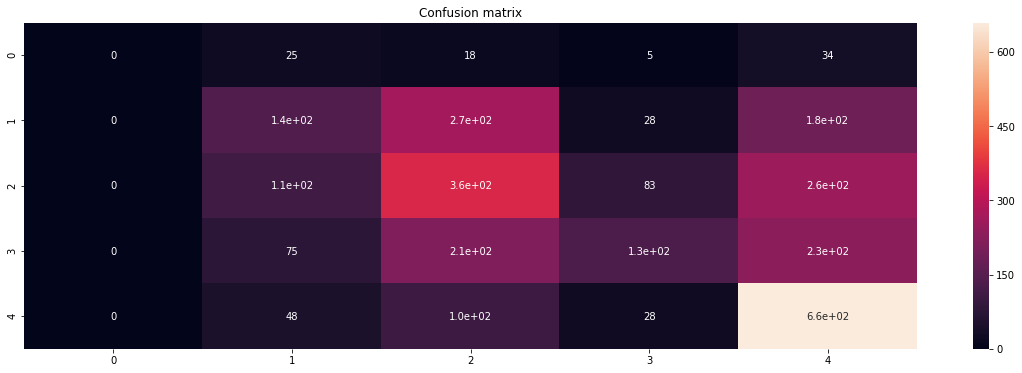

Cohen Kappa: 0.23.
Accuracy Score: 0.43%.
F1 Score: 0.43%.


In [38]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

## XGBoost

More information on parameters tuning in: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [39]:
n_estimators = [100]
learning_rate = [0.7, 0.8,0.9,1]
max_depth =[3,4,5]
colsample_bytree=[0.3]

# Create the random grid
gridParams = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'colsample_bytree': colsample_bytree}


In [40]:
from xgboost.sklearn import XGBClassifier

xgb1 = XGBClassifier()

clf = GridSearchCV(xgb1, gridParams,
                   cv=StratifiedKFold(n_splits  =5), 
                   refit=True, verbose=2)

# Fit the random search model
clf.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=3, learning_rate=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=3, learning_rate=0.7, total=  11.7s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=3, learning_rate=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s


[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=3, learning_rate=0.7, total=  12.0s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=3, learning_rate=0.7 
[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=3, learning_rate=0.7, total=  11.2s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=3, learning_rate=0.7 
[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=3, learning_rate=0.7, total=  12.1s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=3, learning_rate=0.7 
[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=3, learning_rate=0.7, total=  11.7s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=0.7 
[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=0.7, total=  13.5s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=0.7 
[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=0.7, total=  14.7s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=4, learn

[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=1, total=  14.8s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=1 
[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=1, total=  13.7s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=1 
[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=1, total=  13.7s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=1 
[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=1, total=  13.4s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=1 
[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=4, learning_rate=1, total=  13.3s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=5, learning_rate=1 
[CV]  n_estimators=100, colsample_bytree=0.3, max_depth=5, learning_rate=1, total=  15.2s
[CV] n_estimators=100, colsample_bytree=0.3, max_depth=5, learning_rate=1 
[CV]  n_es

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 13.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 4, 5], 'colsample_bytree': [0.3], 'n_estimators': [100], 'learning_rate': [0.7, 0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [41]:
clf.best_params_

{'colsample_bytree': 0.3,
 'learning_rate': 0.7,
 'max_depth': 4,
 'n_estimators': 100}

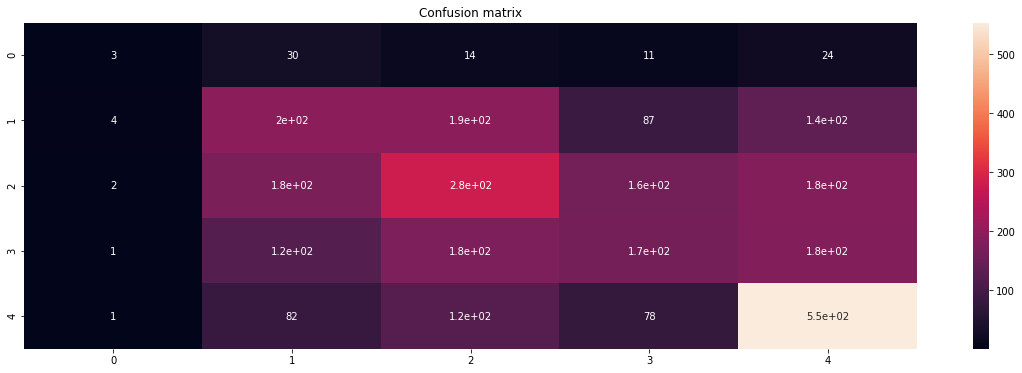

Cohen Kappa: 0.20.
Accuracy Score: 0.40%.
F1 Score: 0.40%.


In [42]:

best_xgb = clf.best_estimator_
xgb_accuracy = evaluate(best_xgb, X_test, y_test)

## Decision Tree Classifier

In [43]:
criterion =['gini','entropy']

max_depth =[3,4,5]
min_samples_leaf  = [2,3,4]

# Create the random grid
gridParams = {'criterion': criterion,
               'min_samples_leaf': min_samples_leaf,
               'max_depth': max_depth}


In [44]:
dt = DecisionTreeClassifier()

dt_cv = GridSearchCV(dt, gridParams,
                   cv=StratifiedKFold(n_splits  =5), 
                   refit=True, verbose=2)

# Fit the random search model
dt_cv.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] criterion=gini, max_depth=3, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=2 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .. criterion=gini, max_depth=3, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=2 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=2, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=3 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=3 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=3 .................
[CV] .. criterion=gini, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] criterion=gini, max_depth=3, min_samples_leaf=3 .................
[CV] .

[CV]  criterion=entropy, max_depth=3, min_samples_leaf=4, total=   0.0s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=2 ..............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=2, total=   0.1s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=2 ..............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=2, total=   0.1s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=2 ..............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=2, total=   0.1s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=2 ..............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=2, total=   0.1s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=2 ..............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=2, total=   0.1s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=3 ..............
[CV]  criterion=entropy, max_depth=4, min_samples_leaf=3, total=   0.1s
[CV] criterion=entropy, max_depth=4, min_samples_leaf=3 ..............

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   14.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': [2, 3, 4], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

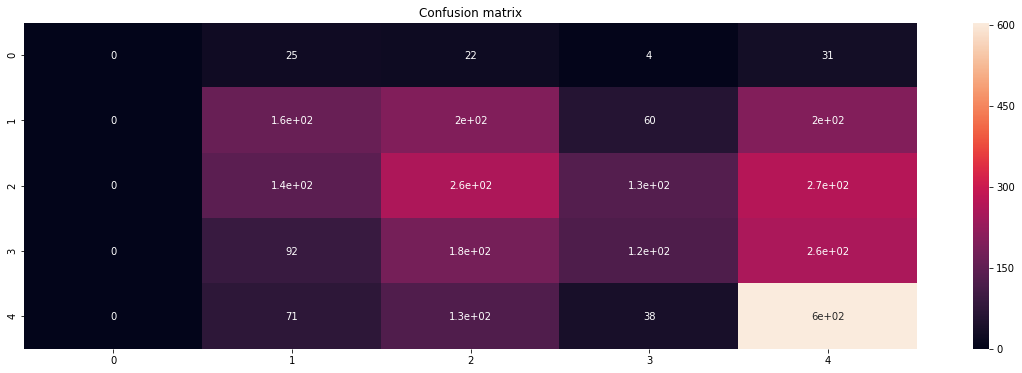

Cohen Kappa: 0.17.
Accuracy Score: 0.38%.
F1 Score: 0.38%.


In [45]:
best_dt = dt_cv.best_estimator_
dt_accuracy = evaluate(best_dt, X_test, y_test)

## LightGBM

In [46]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    'learning_rate': [0.005, 0.05, 0.1],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# To view the default model params:
mdl.get_params().keys()



dict_keys(['scale_pos_weight', 'colsample_bytree', 'n_estimators', 'learning_rate', 'reg_alpha', 'subsample_for_bin', 'n_jobs', 'importance_type', 'subsample', 'boosting_type', 'subsample_freq', 'objective', 'max_bin', 'silent', 'class_weight', 'min_child_weight', 'random_state', 'min_split_gain', 'max_depth', 'min_child_samples', 'reg_lambda', 'num_leaves'])

In [47]:
lgb_cv = GridSearchCV(mdl, gridParams,
                   cv=StratifiedKFold(n_splits  =5), 
                   refit=True, verbose=2)

# Fit the random search model
lgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gb

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boo

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, lea

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbd

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_t

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boostin

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=1

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.4s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_ty

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, bo

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_ra

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, lear

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, lea

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_ty

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_typ

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.5s
[CV] objective=binary, num_leaves=12, boosting_typ

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.4s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, le

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbd

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boost

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learn

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learni

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, lea

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, 

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, le

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_t

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.4s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learnin

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbd

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.75, random_state=501, total=   0.4s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.4s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.65, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_ty

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gb

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boo

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=8, boosting_type

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.4s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.4s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.6s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, le

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_t

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.4s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.4s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.4s
[CV] objective=binary, num_leaves=1

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.5s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.5s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.6s
[CV] objective=binary, num_leaves=16, boosting_type=gbd

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.4s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_ty

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.005, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.4s
[CV] objective=binary, num_leaves=16, bo

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, l

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, le

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=8, boosting_type

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learn

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_typ

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, bo

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbd

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.05, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boost

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, lea

[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=6, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=6, boosting_type=gbdt, l

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1,

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learni

[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=8, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=8, boosting_type

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learnin

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, l

[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=12, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.2s
[CV] objective=binary, num_leaves=12, boosting_typ

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.7, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.2, n_estimators=40, reg_alpha=1, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, 

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbd

[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s
[CV] objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501 
[CV]  objective=binary, num_leaves=16, boosting_type=gbdt, learning_rate=0.1, reg_lambda=1.4, n_estimators=40, reg_alpha=1.2, colsample_bytree=0.66, subsample=0.75, random_state=501, total=   0.3s


[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 11.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_bin=512,
        max_depth=-1, min_child_samples=5, min_child_weight=1,
        min_split_gain=0.5, n_estimators=100, n_jobs=3, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=1,
        subsample_for_bin=200, subsample_freq=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'objective': ['binary'], 'n_estimators': [40], 'boosting_type': ['gbdt'], 'learning_rate': [0.005, 0.05, 0.1], 'reg_lambda': [1, 1.2, 1.4], 'num_leaves': [6, 8, 12, 16], 'reg_alpha': [1, 1.2], 'colsample_bytree': [0.65, 0.66], 'subsample': [0.7, 0.75], 'random_state': [501]},
       pre_dispatch='2*n_jobs', refit=True, return_train_sco

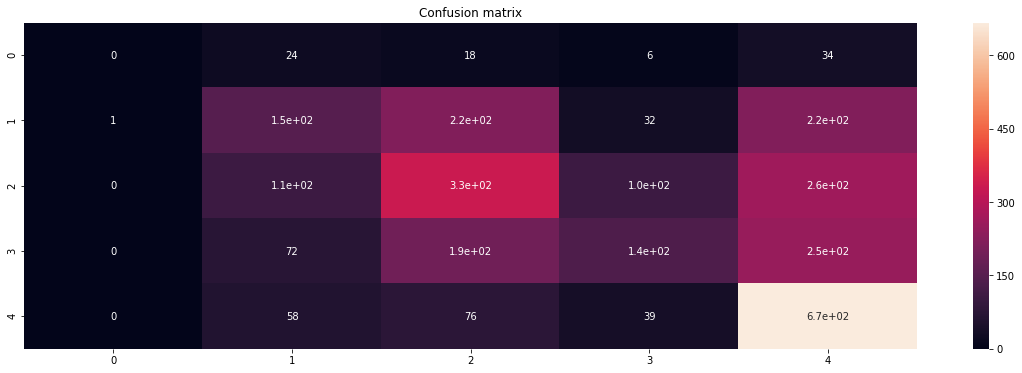

Cohen Kappa: 0.23.
Accuracy Score: 0.43%.
F1 Score: 0.43%.


In [48]:
best_lgb = lgb_cv.best_estimator_
dt_accuracy = evaluate(best_lgb, X_test, y_test)

## Principal Component Analysis (PCA) Before modeling 

Reduce the feature space

## Neural Network 